In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pybaseball import statcast
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import fisher_exact
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

positive_events = {
        'walk', 'single', 'double', 'triple', 'home_run',
        'hit_by_pitch', 'catcher_interf'
}
negative_events = {
        'field_out', 'strikeout', 'strikeout_double_play',
        'grounded_into_double_play', 'double_play', 'triple_play',
        'fielders_choice_out', 'force_out', 'sac_bunt',
        'sac_fly', 'sac_fly_double_play', 'field_error'
}

def classify_event(event):

    if event in positive_events:
        return "positive"
    elif event in negative_events:
        return "negative"
    else:
        return "neutral"

def classify_count_state(row):
    if row['balls'] > row['strikes']:
        return 'hitter_adv'
    elif row['balls'] == row['strikes']:
        return 'even'
    else:
        return 'pitcher_adv'

def analyze_and_compare(year, min_pitches=30):
    print(f"\n=== Analyzing season {year} ===")
    
    start_date = f"{year}-03-01"
    end_date = f"{year}-10-01"
    
    data = statcast(start_date, end_date)
    cols = ['game_date', 'batter', 'pitcher', 'balls', 'strikes', 'pitch_type', 'events']
    df = data[cols].dropna(subset=['events']).copy()

    # Classify events and count states
    df['event_type'] = df['events'].apply(classify_event)
    df = df[df['event_type'] != 'neutral'].copy()
    df['count_state'] = df.apply(classify_count_state, axis=1)
    df['is_positive'] = (df['event_type'] == 'positive').astype(int)

    # Aggregate positive rate per batter on all plays
    agg = df.groupby('batter')['is_positive'].agg(['sum', 'count']).reset_index()
    agg['positive_rate'] = agg['sum'] / agg['count']
    agg_filtered = agg[agg['count'] >= min_pitches].copy()

    if agg_filtered.empty:
        print(f"No batters with minimum {min_pitches} plays.")
        return None, None, None, None

    threshold = agg_filtered['positive_rate'].quantile(0.75)
    special = agg_filtered[agg_filtered['positive_rate'] >= threshold]
    others = agg_filtered[agg_filtered['positive_rate'] < threshold]

    if special.empty or others.empty:
        print("Special or others group is empty, cannot perform tests.")
        return None, None, None, None

    # Add is_special to df
    df['is_special'] = df['batter'].isin(special['batter']).astype(int)

    # Weighted positive ratio by count_state and group
    weighted_ratios = df.groupby(['count_state', 'is_special']).apply(
        lambda x: x['is_positive'].sum() / x.shape[0]
    ).reset_index(name='positive_ratio')

    weighted_ratios['group'] = weighted_ratios['is_special'].map({0: 'others', 1: 'special'})
    weighted_ratios = weighted_ratios.drop(columns='is_special')

    # Distribution of events by special vs others and count_state
    pivot_table = pd.crosstab(
        [df['count_state'], df['events']],
        df['is_special'],
        normalize='index'
    ).rename(columns={0: 'others', 1: 'special'})

    # Mann-Whitney U test on positive_rate per batter
    stat_mwu, p_mwu = mannwhitneyu(special['positive_rate'], others['positive_rate'], alternative='greater')

    # Proportions z-test & Fisher exact on all plays
    special_rows = df[df['is_special'] == 1]
    other_rows = df[df['is_special'] == 0]

    special_pos = special_rows['is_positive'].sum()
    special_n = special_rows.shape[0]
    other_pos = other_rows['is_positive'].sum()
    other_n = other_rows.shape[0]

    count = [special_pos, other_pos]
    nobs = [special_n, other_n]

    stat_z, p_z = proportions_ztest(count, nobs, alternative='larger')

    contingency_table = [
        [int(special_pos), int(special_n - special_pos)],
        [int(other_pos), int(other_n - other_pos)]
    ]
    oddsratio, p_fisher = fisher_exact(contingency_table, alternative='greater')

    # Logistic regression with cluster-robust SE by batter
    try:
        logit = smf.logit('is_positive ~ is_special', data=df).fit(disp=False, cov_type='cluster', cov_kwds={'groups': df['batter']})
        logit_summary = logit.summary2().tables[1]
    except Exception as e:
        logit_summary = None
        print(f"Logistic regression failed: {e}")

    # GEE model clustered by batter
    try:
        gee = smf.gee('is_positive ~ is_special', groups='batter', data=df, family=sm.families.Binomial()).fit()
        gee_summary = gee.summary2().tables[1]
    except Exception as e:
        gee_summary = None
        print(f"GEE model failed: {e}")

    # Print key results
    print(f"Special group threshold positive_rate >= {threshold:.4f}")
    print(f"Mann-Whitney U test: stat={stat_mwu:.4f}, p={p_mwu:.4g}")
    print(f"Proportions Z-test: stat={stat_z:.4f}, p={p_z:.4g}")
    print(f"Fisher's Exact test: oddsratio={oddsratio:.4f}, p={p_fisher:.4g}")

    # Count state bazlı positive event yüzdeleri
    count_state_ratios = (
        df.groupby('count_state')['is_positive']
          .mean()
          .reset_index(name='positive_event_percentage')
    )
    print("\nPositive Event Percentages by Count State:")
    for _, row in count_state_ratios.iterrows():
        print(f"  {row['count_state']}: {row['positive_event_percentage']*100:.2f}%")


    return df, pivot_table, weighted_ratios, {
        'mwu_stat': stat_mwu,
        'mwu_p': p_mwu,
        'z_stat': stat_z,
        'z_p': p_z,
        'fisher_oddsratio': oddsratio,
        'fisher_p': p_fisher,
        'logit_summary': logit_summary,
        'gee_summary': gee_summary,
        'special_threshold': threshold,
        'special_count': len(special),
        'others_count': len(others),
    }

def plot_positive_event_distribution(df, year):
    # Positive event'leri filtrele
    df_positive = df[df['events'].isin(positive_events)].copy()

    # Grup isimleri
    df_positive['group'] = df_positive['is_special'].map({0: 'others', 1: 'special'})

    # Pivot tablo (normalize edilmiş)
    pivot = df_positive.groupby(['group', 'events']).size().reset_index(name='count')
    pivot['ratio'] = pivot.groupby('group')['count'].transform(lambda x: x / x.sum())

    print(f"\n{year} Positive Event Distribution Table:")
    print(pivot.pivot(index='events', columns='group', values='ratio'))

    # Grafik
    plt.figure(figsize=(8,5))
    sns.barplot(data=pivot, x='events', y='ratio', hue='group')
    plt.title(f'{year} Season: Positive Event Distribution (Sum=1 per Group)')
    plt.ylabel('Ratio')
    plt.ylim(0, 1)
    plt.legend(title='Group')
    plt.tight_layout()
    plt.show()

2020


=== Analyzing season 2020 ===
This is a large query, it may take a moment to complete


c:\Users\Megad\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|██████████| 71/71 [01:10<00:00,  1.01it/s]


Special group threshold positive_rate >= 0.3500
Mann-Whitney U test: stat=40599.0000, p=3.268e-59
Proportions Z-test: stat=20.1976, p=5.139e-91
Fisher's Exact test: oddsratio=1.4350, p=1.701e-89

Positive Event Percentages by Count State:
  even: 27.00%
  hitter_adv: 47.33%
  pitcher_adv: 21.06%

2020 Positive Event Distribution Table:
group             others   special
events                            
catcher_interf  0.001606  0.001796
double          0.132281  0.134963
hit_by_pitch    0.038343  0.039508
home_run        0.107766  0.110236
single          0.440075  0.404614
triple          0.011245  0.011466
walk            0.268683  0.297417


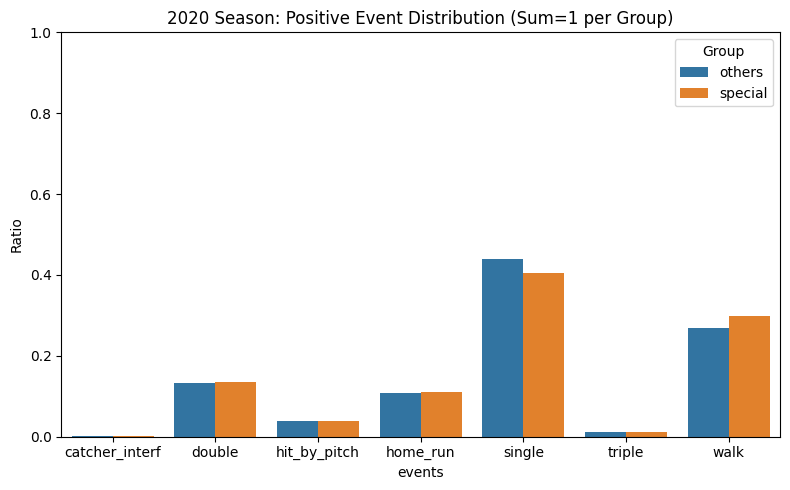


---- 2020 Sezonu ----
Special threshold (positive_rate): 0.3500
Special oyuncu sayısı: 117
Others oyuncu sayısı: 347
Mann-Whitney U testi p değeri: 3.268e-59
Proportions Z-testi p değeri: 5.139e-91
Fisher Exact testi p değeri: 1.701e-89
Logistic Regression (is_special) coef ve p-değeri:
  coef=0.3612, p=1.439e-153
GEE Model (is_special) coef ve p-değeri:
  coef=0.3612, p=7.861e-154


In [8]:
years = 2020
all_results = {}

df, pivot, weighted_ratios, tests = analyze_and_compare(years)
if df is not None:
    all_results[years] = {
        'df': df,
        'pivot': pivot,
        'weighted_ratios': weighted_ratios,
        'tests': tests
    }
    plot_positive_event_distribution(df, years)

# Özet istatistik sonuçları:
for y, res in all_results.items():
    print(f"\n---- {y} Sezonu ----")
    print(f"Special threshold (positive_rate): {res['tests']['special_threshold']:.4f}")
    print(f"Special oyuncu sayısı: {res['tests']['special_count']}")
    print(f"Others oyuncu sayısı: {res['tests']['others_count']}")
    print(f"Mann-Whitney U testi p değeri: {res['tests']['mwu_p']:.4g}")
    print(f"Proportions Z-testi p değeri: {res['tests']['z_p']:.4g}")
    print(f"Fisher Exact testi p değeri: {res['tests']['fisher_p']:.4g}")

    print("Logistic Regression (is_special) coef ve p-değeri:")
    if res['tests']['logit_summary'] is not None:
        coef = res['tests']['logit_summary'].loc['is_special']
        print(f"  coef={coef['Coef.']:.4f}, p={coef['P>|z|']:.4g}")
    else:
        print("  Model başarısız.")

    print("GEE Model (is_special) coef ve p-değeri:")
    if res['tests']['gee_summary'] is not None:
        coef = res['tests']['gee_summary'].loc['is_special']
        print(f"  coef={coef['Coef.']:.4f}, p={coef['P>|z|']:.4g}")
    else:
        print("  Model başarısız.")


2021


=== Analyzing season 2021 ===
This is a large query, it may take a moment to complete


c:\Users\Megad\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|██████████| 201/201 [03:00<00:00,  1.11it/s]


Special group threshold positive_rate >= 0.3336
Mann-Whitney U test: stat=81675.0000, p=6.649e-83
Proportions Z-test: stat=29.9377, p=3.186e-197
Fisher's Exact test: oddsratio=1.3508, p=2.03e-195

Positive Event Percentages by Count State:
  even: 28.10%
  hitter_adv: 47.81%
  pitcher_adv: 19.67%

2021 Positive Event Distribution Table:
group             others   special
events                            
catcher_interf  0.001157  0.000881
double          0.142353  0.135821
hit_by_pitch    0.037572  0.037759
home_run        0.101394  0.107552
single          0.447912  0.425202
triple          0.012864  0.011132
walk            0.256749  0.281653


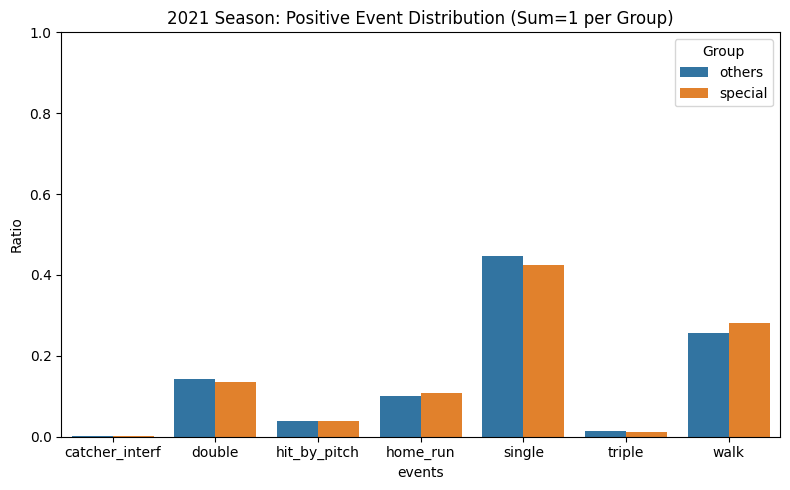


---- 2021 Sezonu ----
Special threshold (positive_rate): 0.3336
Special oyuncu sayısı: 165
Others oyuncu sayısı: 495
Mann-Whitney U testi p değeri: 6.649e-83
Proportions Z-testi p değeri: 3.186e-197
Fisher Exact testi p değeri: 2.03e-195
Logistic Regression (is_special) coef ve p-değeri:
  coef=0.3007, p=2.006e-180
GEE Model (is_special) coef ve p-değeri:
  coef=0.3007, p=1.481e-180


In [9]:
years = 2021
all_results = {}

df, pivot, weighted_ratios, tests = analyze_and_compare(years)
if df is not None:
    all_results[years] = {
        'df': df,
        'pivot': pivot,
        'weighted_ratios': weighted_ratios,
        'tests': tests
    }
    plot_positive_event_distribution(df, years)

# Özet istatistik sonuçları:
for y, res in all_results.items():
    print(f"\n---- {y} Sezonu ----")
    print(f"Special threshold (positive_rate): {res['tests']['special_threshold']:.4f}")
    print(f"Special oyuncu sayısı: {res['tests']['special_count']}")
    print(f"Others oyuncu sayısı: {res['tests']['others_count']}")
    print(f"Mann-Whitney U testi p değeri: {res['tests']['mwu_p']:.4g}")
    print(f"Proportions Z-testi p değeri: {res['tests']['z_p']:.4g}")
    print(f"Fisher Exact testi p değeri: {res['tests']['fisher_p']:.4g}")

    print("Logistic Regression (is_special) coef ve p-değeri:")
    if res['tests']['logit_summary'] is not None:
        coef = res['tests']['logit_summary'].loc['is_special']
        print(f"  coef={coef['Coef.']:.4f}, p={coef['P>|z|']:.4g}")
    else:
        print("  Model başarısız.")

    print("GEE Model (is_special) coef ve p-değeri:")
    if res['tests']['gee_summary'] is not None:
        coef = res['tests']['gee_summary'].loc['is_special']
        print(f"  coef={coef['Coef.']:.4f}, p={coef['P>|z|']:.4g}")
    else:
        print("  Model başarısız.")


2022


=== Analyzing season 2022 ===
This is a large query, it may take a moment to complete


c:\Users\Megad\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|██████████| 201/201 [04:00<00:00,  1.19s/it]


Special group threshold positive_rate >= 0.3276
Mann-Whitney U test: stat=73476.0000, p=7.345e-79
Proportions Z-test: stat=25.9125, p=2.408e-148
Fisher's Exact test: oddsratio=1.3063, p=1.179e-146

Positive Event Percentages by Count State:
  even: 27.81%
  hitter_adv: 47.36%
  pitcher_adv: 20.07%

2022 Positive Event Distribution Table:
group             others   special
events                            
catcher_interf  0.001107  0.001562
double          0.143195  0.141085
hit_by_pitch    0.035031  0.040244
home_run        0.093819  0.096384
single          0.465120  0.441494
triple          0.012357  0.010337
walk            0.249371  0.268893


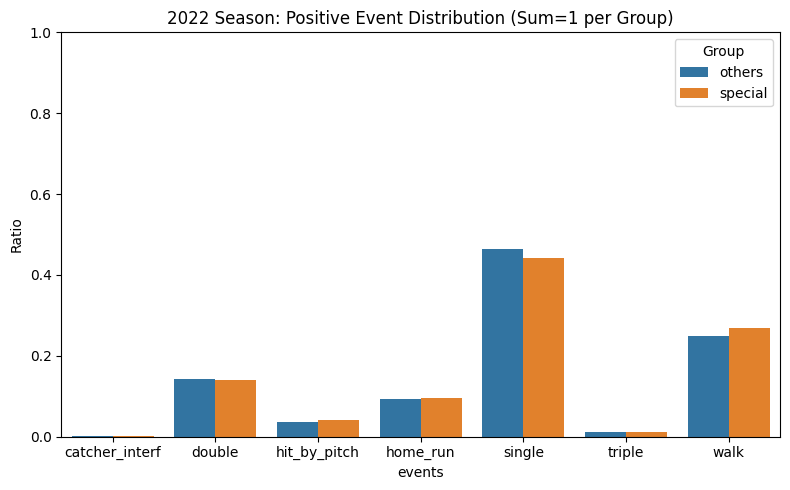


---- 2022 Sezonu ----
Special threshold (positive_rate): 0.3276
Special oyuncu sayısı: 157
Others oyuncu sayısı: 468
Mann-Whitney U testi p değeri: 7.345e-79
Proportions Z-testi p değeri: 2.408e-148
Fisher Exact testi p değeri: 1.179e-146
Logistic Regression (is_special) coef ve p-değeri:
  coef=0.2672, p=2.488e-141
GEE Model (is_special) coef ve p-değeri:
  coef=0.2672, p=2.046e-141


In [10]:
years = 2022
all_results = {}

df, pivot, weighted_ratios, tests = analyze_and_compare(years)
if df is not None:
    all_results[years] = {
        'df': df,
        'pivot': pivot,
        'weighted_ratios': weighted_ratios,
        'tests': tests
    }
    plot_positive_event_distribution(df, years)

# Özet istatistik sonuçları:
for y, res in all_results.items():
    print(f"\n---- {y} Sezonu ----")
    print(f"Special threshold (positive_rate): {res['tests']['special_threshold']:.4f}")
    print(f"Special oyuncu sayısı: {res['tests']['special_count']}")
    print(f"Others oyuncu sayısı: {res['tests']['others_count']}")
    print(f"Mann-Whitney U testi p değeri: {res['tests']['mwu_p']:.4g}")
    print(f"Proportions Z-testi p değeri: {res['tests']['z_p']:.4g}")
    print(f"Fisher Exact testi p değeri: {res['tests']['fisher_p']:.4g}")

    print("Logistic Regression (is_special) coef ve p-değeri:")
    if res['tests']['logit_summary'] is not None:
        coef = res['tests']['logit_summary'].loc['is_special']
        print(f"  coef={coef['Coef.']:.4f}, p={coef['P>|z|']:.4g}")
    else:
        print("  Model başarısız.")

    print("GEE Model (is_special) coef ve p-değeri:")
    if res['tests']['gee_summary'] is not None:
        coef = res['tests']['gee_summary'].loc['is_special']
        print(f"  coef={coef['Coef.']:.4f}, p={coef['P>|z|']:.4g}")
    else:
        print("  Model başarısız.")


2023


=== Analyzing season 2023 ===
This is a large query, it may take a moment to complete


c:\Users\Megad\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|██████████| 201/201 [04:45<00:00,  1.42s/it]


Special group threshold positive_rate >= 0.3333
Mann-Whitney U test: stat=69309.0000, p=8.922e-77
Proportions Z-test: stat=25.3948, p=1.438e-142
Fisher's Exact test: oddsratio=1.2958, p=4.37e-141

Positive Event Percentages by Count State:
  even: 28.37%
  hitter_adv: 47.54%
  pitcher_adv: 20.65%

2023 Positive Event Distribution Table:
group             others   special
events                            
catcher_interf  0.001776  0.001375
double          0.146782  0.132434
hit_by_pitch    0.034797  0.039429
home_run        0.097263  0.102009
single          0.457928  0.423604
triple          0.012528  0.011886
walk            0.248927  0.289262


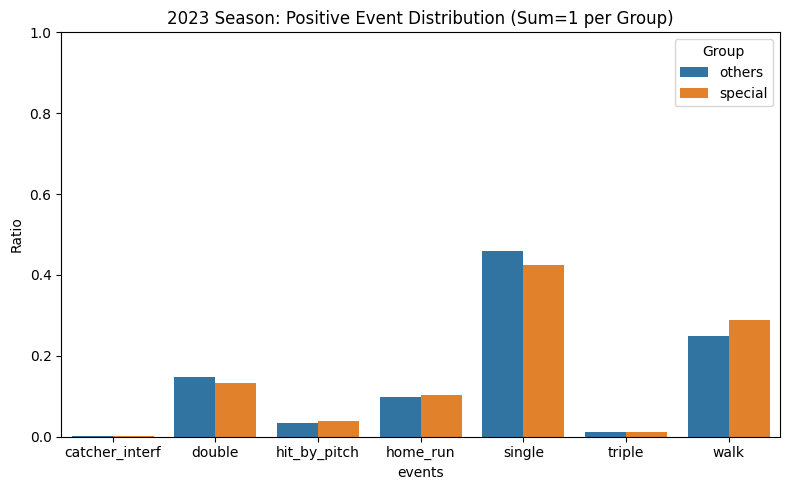


---- 2023 Sezonu ----
Special threshold (positive_rate): 0.3333
Special oyuncu sayısı: 153
Others oyuncu sayısı: 453
Mann-Whitney U testi p değeri: 8.922e-77
Proportions Z-testi p değeri: 1.438e-142
Fisher Exact testi p değeri: 4.37e-141
Logistic Regression (is_special) coef ve p-değeri:
  coef=0.2591, p=7.302e-147
GEE Model (is_special) coef ve p-değeri:
  coef=0.2591, p=5.858e-147


In [11]:
years = 2023
all_results = {}

df, pivot, weighted_ratios, tests = analyze_and_compare(years)
if df is not None:
    all_results[years] = {
        'df': df,
        'pivot': pivot,
        'weighted_ratios': weighted_ratios,
        'tests': tests
    }
    plot_positive_event_distribution(df, years)

# Özet istatistik sonuçları:
for y, res in all_results.items():
    print(f"\n---- {y} Sezonu ----")
    print(f"Special threshold (positive_rate): {res['tests']['special_threshold']:.4f}")
    print(f"Special oyuncu sayısı: {res['tests']['special_count']}")
    print(f"Others oyuncu sayısı: {res['tests']['others_count']}")
    print(f"Mann-Whitney U testi p değeri: {res['tests']['mwu_p']:.4g}")
    print(f"Proportions Z-testi p değeri: {res['tests']['z_p']:.4g}")
    print(f"Fisher Exact testi p değeri: {res['tests']['fisher_p']:.4g}")

    print("Logistic Regression (is_special) coef ve p-değeri:")
    if res['tests']['logit_summary'] is not None:
        coef = res['tests']['logit_summary'].loc['is_special']
        print(f"  coef={coef['Coef.']:.4f}, p={coef['P>|z|']:.4g}")
    else:
        print("  Model başarısız.")

    print("GEE Model (is_special) coef ve p-değeri:")
    if res['tests']['gee_summary'] is not None:
        coef = res['tests']['gee_summary'].loc['is_special']
        print(f"  coef={coef['Coef.']:.4f}, p={coef['P>|z|']:.4g}")
    else:
        print("  Model başarısız.")


2024


=== Analyzing season 2024 ===
This is a large query, it may take a moment to complete


c:\Users\Megad\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|██████████| 201/201 [03:59<00:00,  1.19s/it]


Special group threshold positive_rate >= 0.3260
Mann-Whitney U test: stat=64827.0000, p=4.391e-74
Proportions Z-test: stat=24.6641, p=1.298e-134
Fisher's Exact test: oddsratio=1.2934, p=4.222e-133

Positive Event Percentages by Count State:
  even: 27.31%
  hitter_adv: 46.61%
  pitcher_adv: 20.70%

2024 Positive Event Distribution Table:
group             others   special
events                            
catcher_interf  0.001684  0.002038
double          0.140466  0.134761
hit_by_pitch    0.034064  0.038997
home_run        0.093491  0.102019
single          0.472277  0.433994
triple          0.013013  0.011799
walk            0.245005  0.276393


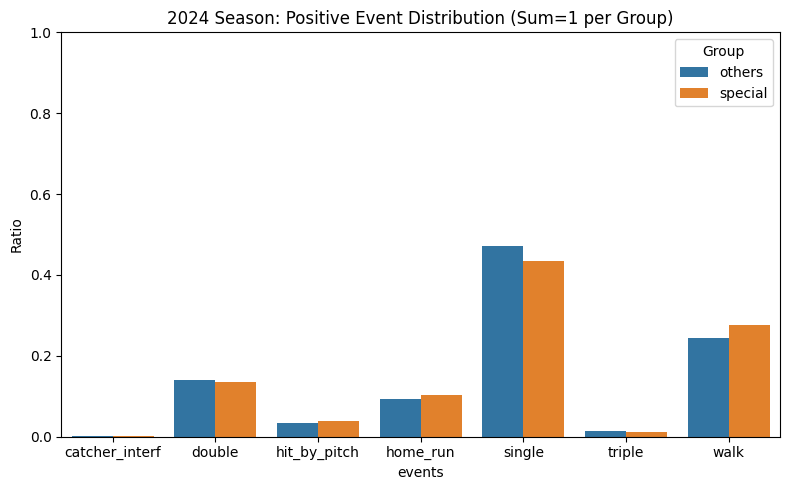


---- 2024 Sezonu ----
Special threshold (positive_rate): 0.3260
Special oyuncu sayısı: 147
Others oyuncu sayısı: 441
Mann-Whitney U testi p değeri: 4.391e-74
Proportions Z-testi p değeri: 1.298e-134
Fisher Exact testi p değeri: 4.222e-133
Logistic Regression (is_special) coef ve p-değeri:
  coef=0.2572, p=2.271e-119
GEE Model (is_special) coef ve p-değeri:
  coef=0.2572, p=1.878e-119


In [12]:
years = 2024
all_results = {}

df, pivot, weighted_ratios, tests = analyze_and_compare(years)
if df is not None:
    all_results[years] = {
        'df': df,
        'pivot': pivot,
        'weighted_ratios': weighted_ratios,
        'tests': tests
    }
    plot_positive_event_distribution(df, years)

# Özet istatistik sonuçları:
for y, res in all_results.items():
    print(f"\n---- {y} Sezonu ----")
    print(f"Special threshold (positive_rate): {res['tests']['special_threshold']:.4f}")
    print(f"Special oyuncu sayısı: {res['tests']['special_count']}")
    print(f"Others oyuncu sayısı: {res['tests']['others_count']}")
    print(f"Mann-Whitney U testi p değeri: {res['tests']['mwu_p']:.4g}")
    print(f"Proportions Z-testi p değeri: {res['tests']['z_p']:.4g}")
    print(f"Fisher Exact testi p değeri: {res['tests']['fisher_p']:.4g}")

    print("Logistic Regression (is_special) coef ve p-değeri:")
    if res['tests']['logit_summary'] is not None:
        coef = res['tests']['logit_summary'].loc['is_special']
        print(f"  coef={coef['Coef.']:.4f}, p={coef['P>|z|']:.4g}")
    else:
        print("  Model başarısız.")

    print("GEE Model (is_special) coef ve p-değeri:")
    if res['tests']['gee_summary'] is not None:
        coef = res['tests']['gee_summary'].loc['is_special']
        print(f"  coef={coef['Coef.']:.4f}, p={coef['P>|z|']:.4g}")
    else:
        print("  Model başarısız.")
